# SENG 550 Term Project
### Air Quality in Dublin Classifier and Prediction Model

Made by Joshua Debele, Tamerlan Ormanbayev

Create a **Spark session** first.

In [53]:
#Importing PySpark Libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, when, mean, regexp_extract, regexp_replace, trim, to_date, concat
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler

#Create a SparkSession
spark = SparkSession.builder.appName('CO_Data').config('spark.sql.debug.maxToStringFields', 1000).config('spark.driver.maxResultSize', '4g').config('spark.executor.memory', '8g').config('spark.sql.broadcastTimeout', '600').config('spark.sql.shuffle.partitions', '200').config('spark.sql.autoBroadcastJoinThreshold', -1).config('spark.executor.cores', '2').getOrCreate() 

Next, we read the dataset, while getting rid of the first rows with comments.

We give our own names to columns, since there are two monitoring sites present in the dataset.

We also create a spark DataFrame from the table with our new column names for easier transformation process.

In [54]:
#Reading the dataset
raw_data = spark.read.text('dublin-city-council-co-2011p20110929-1048.csv')
no_header = raw_data.rdd.zipWithIndex().filter(lambda x: 15 <= x[1] <= 3646).map(lambda x: x[0])

#Naming the columns so it is clear that a set of features belong to Winetavern Street Site and another set belong to Coleraine Street
cols = ['Date', 'Time', 'CO_Winetavern', '8hr_Winetavern', 'Flag_Winetavern', 'Comment_Winetavern', 'CO_Coleraine', '8hr_Coleraine', 'Flag_Coleraine', 'Comment_Coleraine']

#Creating a DataFrame from the raw data
df = spark.read.csv(no_header, header=False, inferSchema=True)
df = df.toDF(*cols)

Now, we clean the data. We convert the received columns into proper types. The dataset that we chose had a lot of empty rows, and also rows with foreign entries such as 'cal', 'Service', 'No data' or 'Zero Air'.

In [55]:
#Data Clean Up - Parsing the CSV file's data correctly
df = df.withColumn("Date", regexp_extract(col("Date"), r"(\d{2}/\d{2}/\d{4})", 1)) \
       .withColumn("Date", to_date(col("Date"), "dd/MM/yyyy")) \
       .withColumn("Comment_Winetavern", trim(regexp_replace(col("Comment_Winetavern"), r"[')]", ""))) \
       .withColumn("Comment_Winetavern", when(col("Comment_Winetavern").isNull(), "").otherwise(col("Comment_Winetavern"))) \
       .withColumn("Comment_Coleraine", trim(regexp_replace(col("Comment_Coleraine"), r"[')]", ""))) \
       .withColumn("Comment_Coleraine", when(col("Comment_Coleraine").isNull(), "").otherwise(col("Comment_Coleraine")))

df = df.withColumn("Day", col("Date").cast("date").cast("string").substr(9, 2).cast("int")) \
       .withColumn("Month", col("Date").cast("date").cast("string").substr(6, 2).cast("int")) \
       .withColumn("Year", col("Date").cast("date").cast("string").substr(1, 4).cast("int"))

#Handles Invalid values such as #DIV/0! by replacing them with None      
for col_name in ["CO_Winetavern", "CO_Coleraine", "8hr_Winetavern", "8hr_Coleraine"]:
    df = df.withColumn(col_name, when(col(col_name) == "#DIV/0!", lit(None)).otherwise(col(col_name).cast('double')))

#Changing the Flag Column Type into an Int Type
df = df.withColumn("Flag_Winetavern", col("Flag_Winetavern").cast('int')) \
       .withColumn("Flag_Coleraine", col("Flag_Coleraine").cast('int'))

After the data has been cleaned, we are able to calculate the mean CO values, along with making a new target column.

The classification_sitename column is where we assign categories based on the calculated 8 hour averages. The categories range from "Low" to "Moderate", "High" and "Very High". All of the threshold values were chosen based on the dataset itself.

In [56]:
#Finding the mean for the CO levels in both sites
mean_CO_Winetavern = df.select(mean('CO_Winetavern')).first()[0]
mean_CO_Coleraine = df.select(mean('CO_Coleraine')).first()[0]

mean_8hr_Winetavern = df.select(mean('8hr_Winetavern')).first()[0]
mean_8hr_Coleraine = df.select(mean('8hr_Coleraine')).first()[0]

df = df.fillna({
    '8hr_Winetavern': mean_8hr_Winetavern,
    'Flag_Winetavern': 0,
    '8hr_Coleraine': mean_8hr_Coleraine,
    'Flag_Coleraine': 0
})

df = df.na.fill({'CO_Winetavern': mean_CO_Winetavern, 'CO_Coleraine': mean_CO_Coleraine})

#Adding target columns for each site based on the 8hr rolling average range
df = df.withColumn(
    "classification_winetavern",
    when(col("8hr_Winetavern") <= 0.2, 0)  #0 represents Low 
    .when(col("8hr_Winetavern") <= 0.4, 1) #1 represents Moderate
    .when(col("8hr_Winetavern") <= 0.6, 2) #2 represents High
    .otherwise(3)  #3 represents High
)

df = df.withColumn(
    "classification_coleraine",
    when(col("8hr_Coleraine") <= 0.2, 0)  #0 represents Low 
    .when(col("8hr_Coleraine") <= 0.4, 1) #1 represents Moderate
    .when(col("8hr_Coleraine") <= 0.6, 2) #2 represents High
    .otherwise(3)  #3 represents High
)

df = df.withColumn("classification_winetavern", col("classification_winetavern").cast("integer"))
df = df.withColumn("classification_coleraine", col("classification_coleraine").cast("integer"))

We then build two separate Random Forest Classifiers for both of the monitoring sites. They are separate to avoid any overlap of data from one site with the other, as that can worsen the analysis.

We randomly split our data into training and test sets. Our feature set includes the original CO levels, along with the provided flag of 'data approval' from the dataset. Our target is the category of the record itself, and we do not include the 8 hour averages, since the model would not need to predict anything if we had them.

In [57]:
#Building Two Random Forest Classifiers for Winetavern Street and Coleraine Street respectively
assembler = VectorAssembler(inputCols=[
    'Time','CO_Winetavern', 'Flag_Winetavern', 'CO_Coleraine', 'Flag_Coleraine', 'Day', 'Month', 'Year'
], outputCol="features")
df = assembler.transform(df)

df = df.fillna({'classification_winetavern': 0, 'classification_coleraine': 0})  # Fill missing classification values with 0
# Combine classifications into a single column
df = df.withColumn(
    "combined_classification",
    concat(col("classification_winetavern").cast("string"), lit("_"), col("classification_coleraine").cast("string"))
)
# Create fractions map for combined classifications
fractions = df.groupBy("combined_classification") \
    .count() \
    .rdd \
    .map(lambda row: (row["combined_classification"], row["count"])) \
    .collectAsMap()

# Handle empty fractions
fractions = {k: v for k, v in fractions.items() if k is not None}

# Normalize fractions for stratified sampling
total = sum(fractions.values())
fractions = {k: 0.8 * v / total for k, v in fractions.items()}

# Apply stratified sampling
train_data = df.sampleBy("combined_classification", fractions=fractions, seed=42)
test_data = df.subtract(train_data)
rfc_w = RandomForestClassifier(featuresCol="features", labelCol="classification_winetavern")
rfc_c = RandomForestClassifier(featuresCol="features", labelCol="classification_coleraine")
,
#Training WineTavern and Coleraine Classifiers with Cross-validation
paramGrid_w = ParamGridBuilder().addGrid(rfc_w.numTrees, [50, 100]).addGrid(rfc_w.maxDepth, [5, 10]).build()
crossval_w = CrossValidator(estimator=rfc_w, estimatorParamMaps=paramGrid_w, evaluator=MulticlassClassificationEvaluator(labelCol="classification_winetavern"), numFolds=2, parallelism=4)
cv_model_w = crossval_w.fit(train_data)
rfc_model_w = cv_model_w.bestModel        # Best Performing Winetavern Model
paramGrid_c = ParamGridBuilder().addGrid(rfc_c.numTrees, [50, 100]).addGrid(rfc_c.maxDepth, [5, 10]).build()
crossval_c = CrossValidator(estimator=rfc_c, estimatorParamMaps=paramGrid_c, evaluator=MulticlassClassificationEvaluator(labelCol="classification_coleraine"), numFolds=2, parallelism=4)
cv_model_c = crossval_c.fit(train_data)
rfc_model_c = cv_model_c.bestModel        # Best Performing Coleraine Model

#Make Predictions on each site separately
predictions_w = rfc_model_w.transform(test_data)
predictions_c = rfc_model_c.transform(test_data)

24/12/19 21:22:53 WARN DAGScheduler: Broadcasting large task binary with size 1042.4 KiB
24/12/19 21:22:53 WARN DAGScheduler: Broadcasting large task binary with size 1179.2 KiB
24/12/19 21:22:54 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
24/12/19 21:22:55 WARN DAGScheduler: Broadcasting large task binary with size 1224.3 KiB
24/12/19 21:22:55 WARN DAGScheduler: Broadcasting large task binary with size 1352.4 KiB
24/12/19 21:22:55 WARN DAGScheduler: Broadcasting large task binary with size 1060.7 KiB
24/12/19 21:22:56 WARN DAGScheduler: Broadcasting large task binary with size 1123.0 KiB
24/12/19 21:22:56 WARN DAGScheduler: Broadcasting large task binary with size 1311.8 KiB
24/12/19 21:22:56 WARN DAGScheduler: Broadcasting large task binary with size 1414.9 KiB
24/12/19 21:22:56 WARN DAGScheduler: Broadcasting large task binary with size 1116.7 KiB
24/12/19 21:22:57 WARN DAGScheduler: Broadcasting large task binary with size 1049.6 KiB
24/12/19 21:22:57 WAR

Now, we can proceed with the evaluator for the model.

Here, we are going to look at accuracy, precision, recall, F-score, and training accuracy/error of each model separately. 

In the end, we simply display all of the measured metrics.

In [58]:
#Create Evalutor Model to Measure the model's ability to predict
eval = MulticlassClassificationEvaluator(predictionCol="prediction")

#Evaluate both models using the test data
acc_wine = eval.setMetricName("accuracy").setLabelCol("classification_winetavern").evaluate(predictions_w)
prec_wine = eval.setMetricName("weightedPrecision").setLabelCol("classification_winetavern").evaluate(predictions_w)
recall_wine = eval.setMetricName("weightedRecall").setLabelCol("classification_winetavern").evaluate(predictions_w)
f1_wine = eval.setMetricName("f1").setLabelCol("classification_winetavern").evaluate(predictions_w)

acc_col = eval.setMetricName("accuracy").setLabelCol("classification_coleraine").evaluate(predictions_c)
prec_col = eval.setMetricName("weightedPrecision").setLabelCol("classification_coleraine").evaluate(predictions_c)
recall_col = eval.setMetricName("weightedRecall").setLabelCol("classification_coleraine").evaluate(predictions_c)
f1_col = eval.setMetricName("f1").setLabelCol("classification_coleraine").evaluate(predictions_c)

#Finding Training Accuracy and Training Error for Winetavern Street and Coleraine Street
train_predictions_w = rfc_model_w.transform(train_data)
train_accuracy_w = eval.setMetricName("accuracy").setLabelCol("classification_winetavern").evaluate(train_predictions_w)
train_error_w = 1 - train_accuracy_w

train_predictions_c = rfc_model_c.transform(train_data)
train_accuracy_c = eval.setMetricName("accuracy").setLabelCol("classification_coleraine").evaluate(train_predictions_c)
train_error_c = 1 - train_accuracy_c

#Display the evaluation metrics
print("\nEvaluation Metrics")
print("Winetavern Street - Accuracy: ", acc_wine)
print("Winetavern Street - Precision: ", prec_wine)
print("Winetavern Street - Recall: ", recall_wine)
print("Winetavern Street - F1 Score: ", f1_wine)

print("Winetavern Street - Training Accuracy: ", train_accuracy_w)
print("Winetavern Street - Training Error: ", train_error_w)
print() #Just to add some space

print("Coleraine Street - Accuracy: ", acc_col)
print("Coleraine Street - Precision: ", prec_col)
print("Coleraine Street - Recall: ", recall_col)
print("Coleraine Street - F1 Score: ", f1_col)

print("Coleraine Street - Training Accuracy: ", train_accuracy_c)
print("Coleraine Street - Training Error: ", train_error_c)
print() #Just to add some space


#Display Confusion Matrix
print("Confusion Matrix for Winetavern Street:")
predictions_w.groupBy("classification_winetavern", "prediction").count().show()

print("Confusion Matrix for Coleraine Street:")
predictions_c.groupBy("classification_coleraine", "prediction").count().show()

# Group by classifications and count occurrences
df.groupBy("classification_winetavern").count().show()
df.groupBy("classification_coleraine").count().show()



24/12/19 21:22:58 WARN DAGScheduler: Broadcasting large task binary with size 1030.8 KiB
24/12/19 21:22:58 WARN DAGScheduler: Broadcasting large task binary with size 1030.8 KiB
24/12/19 21:22:59 WARN DAGScheduler: Broadcasting large task binary with size 1030.8 KiB
24/12/19 21:22:59 WARN DAGScheduler: Broadcasting large task binary with size 1030.8 KiB
24/12/19 21:23:00 WARN DAGScheduler: Broadcasting large task binary with size 1564.1 KiB
24/12/19 21:23:00 WARN DAGScheduler: Broadcasting large task binary with size 1564.1 KiB
24/12/19 21:23:01 WARN DAGScheduler: Broadcasting large task binary with size 1564.1 KiB
24/12/19 21:23:01 WARN DAGScheduler: Broadcasting large task binary with size 1564.1 KiB
24/12/19 21:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1496.1 KiB



Evaluation Metrics
Winetavern Street - Accuracy:  0.843400447427293
Winetavern Street - Precision:  0.8442554441449103
Winetavern Street - Recall:  0.843400447427293
Winetavern Street - F1 Score:  0.8372061871867602
Winetavern Street - Training Accuracy:  0.974155069582505
Winetavern Street - Training Error:  0.025844930417495027

Coleraine Street - Accuracy:  0.6711409395973155
Coleraine Street - Precision:  0.684842794808283
Coleraine Street - Recall:  0.6711409395973155
Coleraine Street - F1 Score:  0.6630900746155026
Coleraine Street - Training Accuracy:  0.9204771371769384
Coleraine Street - Training Error:  0.07952286282306165

Confusion Matrix for Winetavern Street:


24/12/19 21:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1029.0 KiB
24/12/19 21:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1017.0 KiB


+-------------------------+----------+-----+
|classification_winetavern|prediction|count|
+-------------------------+----------+-----+
|                        2|       1.0|  105|
|                        1|       0.0|   46|
|                        0|       2.0|    2|
|                        1|       3.0|    6|
|                        3|       1.0|   39|
|                        0|       3.0|    1|
|                        0|       0.0| 1907|
|                        1|       2.0|  105|
|                        2|       3.0|   21|
|                        3|       2.0|  117|
|                        3|       3.0|   90|
|                        2|       2.0|  275|
|                        1|       1.0|  367|
|                        3|       0.0|    7|
|                        2|       0.0|   27|
|                        0|       1.0|   14|
+-------------------------+----------+-----+

Confusion Matrix for Coleraine Street:


24/12/19 21:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1562.2 KiB
24/12/19 21:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1550.2 KiB


+------------------------+----------+-----+
|classification_coleraine|prediction|count|
+------------------------+----------+-----+
|                       2|       1.0|  336|
|                       1|       0.0|   53|
|                       1|       3.0|    8|
|                       3|       1.0|   90|
|                       0|       0.0|  414|
|                       1|       2.0|  110|
|                       2|       3.0|   60|
|                       3|       2.0|  188|
|                       3|       3.0|  247|
|                       2|       2.0|  399|
|                       1|       1.0| 1040|
|                       3|       0.0|    3|
|                       2|       0.0|   17|
|                       0|       1.0|  164|
+------------------------+----------+-----+

+-------------------------+-----+
|classification_winetavern|count|
+-------------------------+-----+
|                        1|  598|
|                        3|  273|
|                        2|  489|
|  

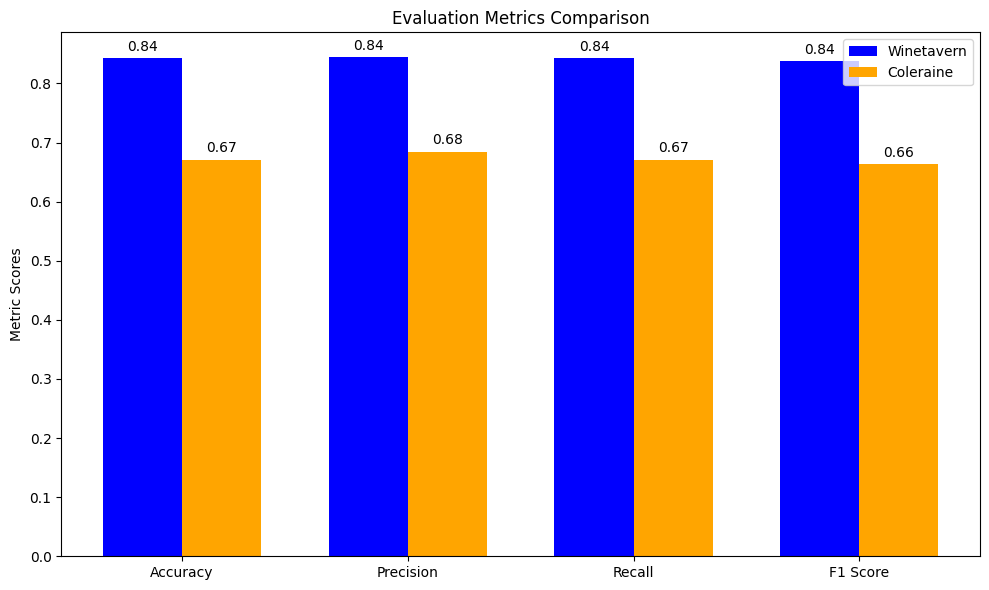

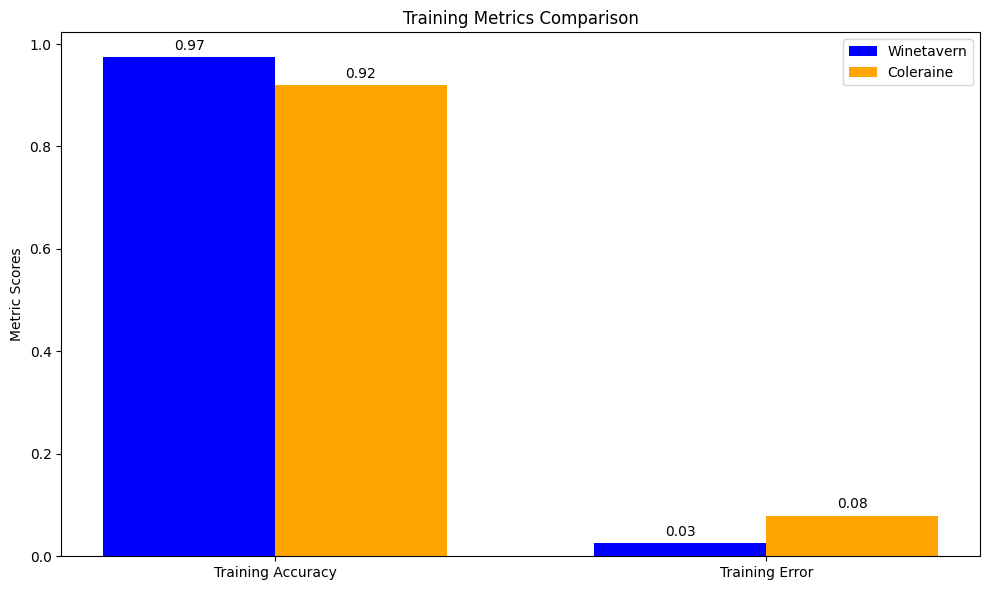

In [59]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
winetavern_metrics = [acc_wine, prec_wine, recall_wine, f1_wine]
coleraine_metrics = [acc_col, prec_col, recall_col, f1_col]

train_metrics = ['Training Accuracy', 'Training Error']
winetavern_train_metrics = [train_accuracy_w, train_error_w]
coleraine_train_metrics = [train_accuracy_c, train_error_c]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, winetavern_metrics, width, label='Winetavern', color='blue')
bars2 = ax.bar(x + width/2, coleraine_metrics, width, label='Coleraine', color='orange')

# Add labels, title, and legend
ax.set_ylabel('Metric Scores')
ax.set_title('Evaluation Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value annotations on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # Format to 2 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset to prevent overlap
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

x_train = np.arange(len(train_metrics))

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x_train - width/2, winetavern_train_metrics, width, label='Winetavern', color='blue')
bars2 = ax.bar(x_train + width/2, coleraine_train_metrics, width, label='Coleraine', color='orange')

ax.set_ylabel('Metric Scores')
ax.set_title('Training Metrics Comparison')
ax.set_xticks(x_train)
ax.set_xticklabels(train_metrics)
ax.legend()

# Add value annotations on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # Format to 2 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset to prevent overlap
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


24/12/19 21:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1029.0 KiB
24/12/19 21:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1015.8 KiB


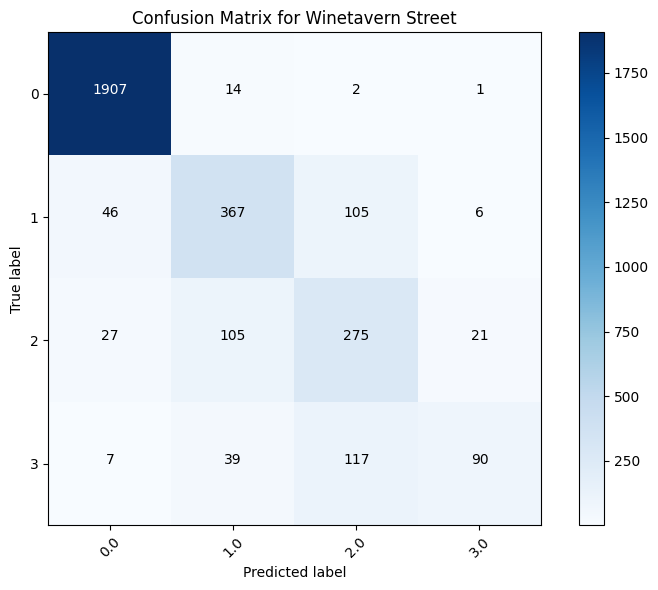

24/12/19 21:23:04 WARN DAGScheduler: Broadcasting large task binary with size 1562.2 KiB
24/12/19 21:23:04 WARN DAGScheduler: Broadcasting large task binary with size 1549.0 KiB


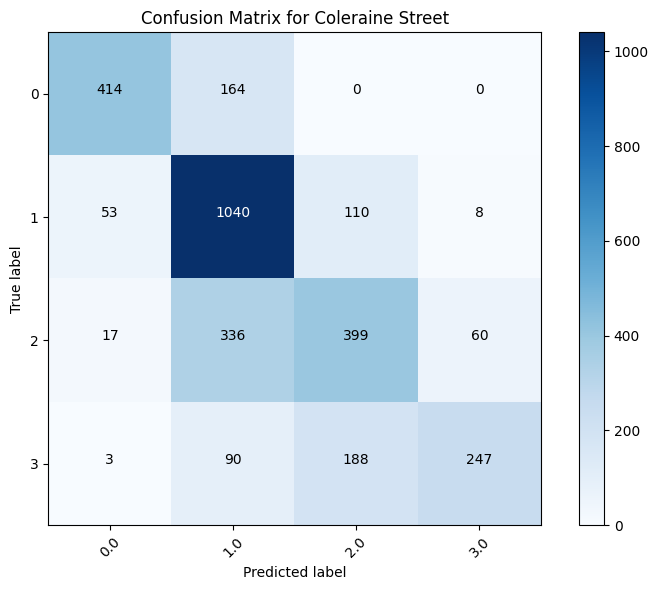

In [60]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(confusion_df, true_col, pred_col, title):
    cm = confusion_df.toPandas().pivot(index=true_col, columns=pred_col, values='count').fillna(0)
    cm_values = cm.values

    plt.figure(figsize=(8, 6))
    plt.imshow(cm_values, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(cm.index))
    plt.xticks(tick_marks, cm.columns, rotation=45)
    plt.yticks(tick_marks, cm.index)

    thresh = cm_values.max() / 2
    for i in range(cm_values.shape[0]):
        for j in range(cm_values.shape[1]):
            plt.text(j, i, int(cm_values[i, j]),
                     horizontalalignment="center",
                     color="white" if cm_values[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

confusion_winetavern = predictions_w.groupBy("classification_winetavern", "prediction").count()

confusion_coleraine = predictions_c.groupBy("classification_coleraine", "prediction").count()

plot_confusion_matrix(
    confusion_winetavern, 
    true_col="classification_winetavern", 
    pred_col="prediction", 
    title="Confusion Matrix for Winetavern Street"
)

plot_confusion_matrix(
    confusion_coleraine, 
    true_col="classification_coleraine", 
    pred_col="prediction", 
    title="Confusion Matrix for Coleraine Street"
)

